### Classification with BHI Dataset and VGG-style network
In this experiment you will set up a VGG-style network to classify histopathologic scans of breast tissue from the [BHI](https://www.kaggle.com/paultimothymooney/breast-histopathology-images) dataset.

In [1]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import SGD, Adam
from matplotlib import pyplot as plt
import numpy as np

Here we use a Keras utility function to load the dataset.  I already organized the data into HDF5 files which are a good format for storing array data.

In [2]:
from tensorflow.keras.utils import get_file
x_train_path = get_file('idc_train.h5','https://storage.googleapis.com/data401-datasets/idc_train.h5')
x_test_path = get_file('idc_test.h5','https://storage.googleapis.com/data401-datasets/idc_test.h5')

We read the data from the HDF5 files into Numpy arrays.

I crop the images so they are all 48x48.

In [3]:
import h5py as h5
with h5.File(x_train_path,'r') as f:
  x_train = f['X'][::2,1:49,1:49] # load half the data to avoid out-of-memory errors
  y_train = f['y'][::2]
with h5.File(x_test_path,'r') as f:
  x_test = f['X'][:,1:49,1:49]
  y_test = f['y'][:]

In [4]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((61925, 48, 48, 3), (61925,), (13761, 48, 48, 3), (13761,))

Showing a few images from the dataset.

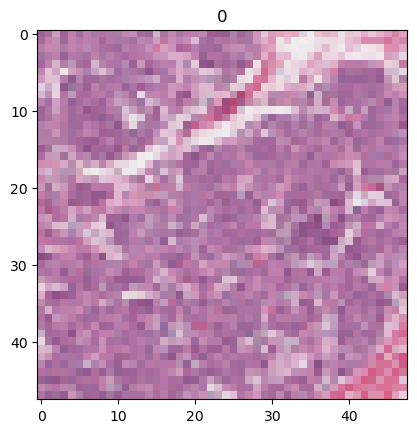

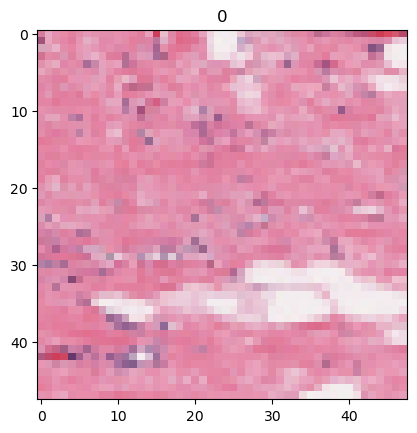

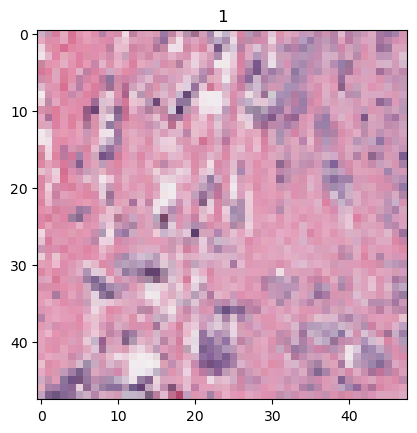

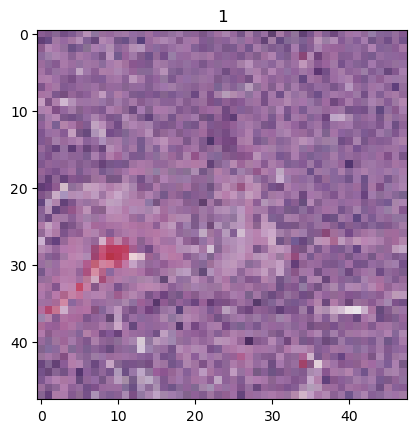

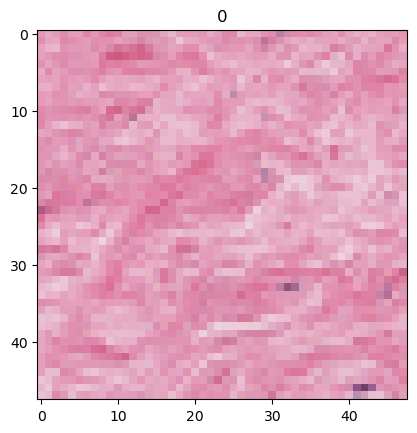

In [5]:
for i in range(5):
  plt.imshow(np.squeeze(x_train[i]))
  plt.title(y_train[i])
  plt.show()

## Data preprocessing

1. Convert the train and test images to floating point and divide by 255.
2. Compute the average value of the entire training image set.
3. Subtract the average value from the training and testing images.


In [6]:
x_test = x_test.astype("float32")/255
x_train = x_train.astype("float32")/255

x_train_avg = np.mean(x_train)

x_train = x_train-x_train_avg
x_test = x_test-x_train_avg


Build a VGG-style binary classifier model.  For example, your network could contain the following:
1. 32 convolutional filters of size 3x3, zero padding, ReLU activation
2. 2x2 max pooling with stride 2
3. 64 filters
4. max pool
5. 128 filters
5. max pool
6. 256 filters
7. max pool
8. flatten
9. Fully-connected layer with 128 outputs
10. Final binary classification layer

In [7]:
model = Sequential([
        Input(x_train.shape[1:]),
        Conv2D(32,3,activation='relu',padding='same',name='conv1'),
        MaxPooling2D(2,2),
        Conv2D(64,3,activation='relu',padding='same',name='conv2'),
        MaxPooling2D(2,2),
        Conv2D(128,3,activation='relu',padding='same',name='conv3'),
        MaxPooling2D(2,2),
        Conv2D(256,3,activation='relu',padding='same',name='conv4'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128,activation='relu',name='dense1'),
        Dense(2,activation='softmax',name='z')
])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 conv2 (Conv2D)              (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 conv3 (Conv2D)              (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 128)        

Set up the model to optimize the sparse categorical cross-entropy loss using Adam optimizer and learning rate of $.0003$.  Calculate accuracy metrics during training.

In [8]:

learning_rate = 3e-4


opt = Adam(learning_rate=learning_rate)

model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics='accuracy')


Now `fit` the model to the data using a batch size of 32 and 10% validation split over 10 epochs.

In [9]:
batch_size = 32
epochs = 10

history = model.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,validation_split=0.1,verbose=True)

Epoch 1/10


1742/1742 [==============================] - 113s 63ms/step - loss: 0.3817 - accuracy: 0.8362 - val_loss: 0.3463 - val_accuracy: 0.8558
Epoch 2/10
1742/1742 [==============================] - 109s 62ms/step - loss: 0.3330 - accuracy: 0.8578 - val_loss: 0.3159 - val_accuracy: 0.8687
Epoch 3/10
1742/1742 [==============================] - 110s 63ms/step - loss: 0.3162 - accuracy: 0.8653 - val_loss: 0.3141 - val_accuracy: 0.8679
Epoch 4/10
1742/1742 [==============================] - 110s 63ms/step - loss: 0.3022 - accuracy: 0.8726 - val_loss: 0.3003 - val_accuracy: 0.8726
Epoch 5/10
1742/1742 [==============================] - 106s 61ms/step - loss: 0.2911 - accuracy: 0.8761 - val_loss: 0.3162 - val_accuracy: 0.8669
Epoch 6/10
1742/1742 [==============================] - 59s 34ms/step - loss: 0.2755 - accuracy: 0.8845 - val_loss: 0.2947 - val_accuracy: 0.8773
Epoch 7/10
1742/1742 [==============================] - 39s 22ms/step - loss: 0.2526 - accuracy: 0.8942 - val_loss: 0

Plot loss and accuracy over the training run.

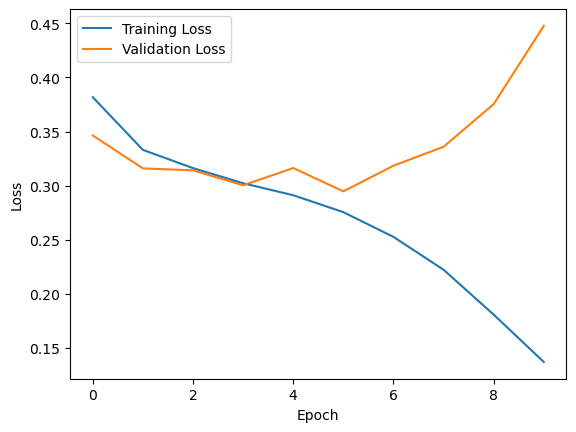

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

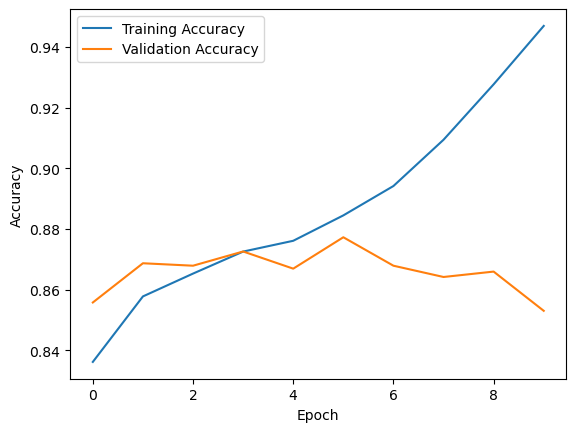

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

Compute accuracy of the model on the training and testing sets.

In [14]:
# Evaluate the model on the training data
loss_train, accuracy_train = model.evaluate(x_train, y_train)
# Evaluate the model on the test data
loss_test, accuracy_test = model.evaluate(x_test, y_test)

print()
print(f"Training Loss: {loss_train:.4f}")
print(f"Training Accuracy: {accuracy_train * 100:.2f}%")
print()
print(f"Test Loss: {loss_test:.4f}")
print(f"Test Accuracy: {accuracy_test * 100:.2f}%")

431/431 [==============================] - 5s 11ms/step - loss: 0.4676 - accuracy: 0.8452

Training Loss: 0.1531
Training Accuracy: 94.53%

Test Loss: 0.4676
Test Accuracy: 84.52%


Try a different setting to see if you can improve the test set accuracy at all.  Write about the results here.